<a href="https://colab.research.google.com/github/cmcneile/google_collab/blob/main/brain_tumor_detection_v2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow 
print("Tensorflow Version: ", tensorflow.__version__)
print("Cuda Availability : ", tensorflow.test.is_built_with_cuda())
print("Num GPUs Available: ", len(tensorflow.config.experimental.list_physical_devices('GPU')))

Tensorflow Version:  2.5.0
Cuda Availability :  True
Num GPUs Available:  0


### IMPORTING LIBRARIES

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import skimage.io
import tqdm
import os

from tqdm import tqdm

from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.color import rgb2gray

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, ZeroPadding2D, Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

%matplotlib inline

### IMPORTING / VIEWING / PRE-PROCESSING DATASET

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!ls -t /content/drive/MyDrive | head
!cp /content/drive/MyDrive/yesNo.zip .
!unzip yesNo.zip



yesNo.zip
Virtualposterday.gslides
MLnotes.gsite
Discon_May11th.gslides
Discon_Utah_corr.gdraw
SQLforSTEMstudents.gsite
DropIn.gslides
QCDandQED_Apr13_2021.gslides
Copy of QCDandQED_Apr13_2021.gslides
QCDandQED_Dec22.gslides
Archive:  yesNo.zip
   creating: yes/
  inflating: yes/Y157.JPG            
  inflating: yes/Y6.jpg              
  inflating: yes/Y194.jpg            
  inflating: yes/Y180.jpg            
  inflating: yes/Y90.jpg             
  inflating: yes/Y47.JPG             
  inflating: yes/Y53.jpg             
  inflating: yes/Y52.jpg             
  inflating: yes/Y46.jpg             
  inflating: yes/Y91.jpg             
  inflating: yes/Y85.JPG             
  inflating: yes/Y181.jpg            
  inflating: yes/Y195.JPG            
  inflating: yes/Y7.jpg              
  inflating: yes/Y156.JPG            
  inflating: yes/Y168.jpg            
  inflating: yes/Y154.jpg            
  inflating: yes/Y183.jpg            
  inflating: yes/Y78.jpg             
  inflating: ye

In [5]:
# Importing Dataset 

cancerous      = os.listdir('yes')
non_cancerous  = os.listdir('no') 

In [ ]:
len(cancerous), len(non_cancerous)

(155, 98)

# Viewing Dataset - Cancerous 

100%|██████████| 5/5 [00:00<00:00, 25.25it/s]


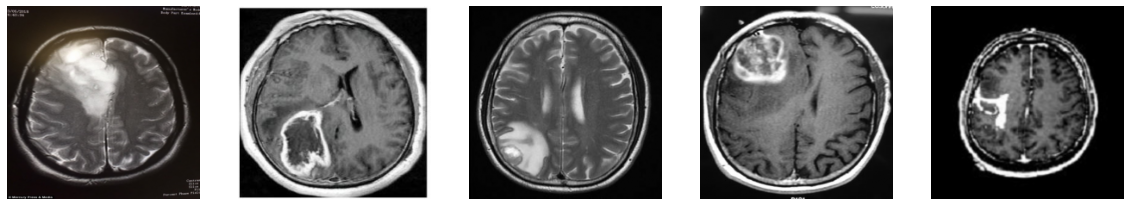

In [6]:


fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = (20,20))

for i in tqdm(range(0, 5)):
    rand = np.random.randint(len(cancerous))
    img  = imread('yes/' + cancerous[rand])
    img  = resize(img, (224,224))
    ax[i].imshow(img)
    ax[i].axis('off')

# Viewing Dataset - Non-Cancerous 

100%|██████████| 5/5 [00:01<00:00,  4.68it/s]


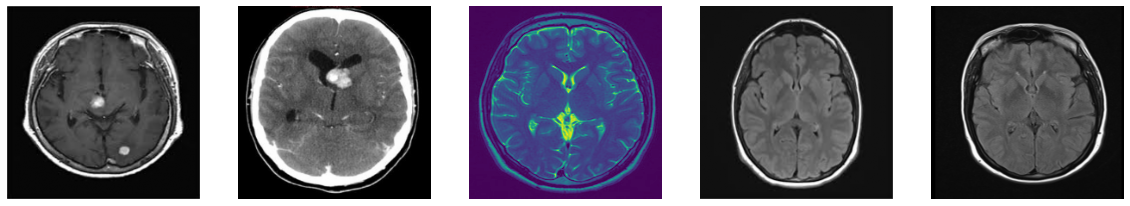

In [7]:


fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = (20,20))

for i in tqdm(range(0, 5)):
    rand = np.random.randint(len(non_cancerous))
    img  = imread('no/' + non_cancerous[rand])
    img  = resize(img, (224,224))
    ax[i].imshow(img)
    ax[i].axis('off')

In [8]:
# Converting images into proper shape and storing tehm as asn array.

Image = []
Label = []

for i in tqdm(range(0, len(cancerous))):
    img = imread('yes/' + cancerous[i])
    img = resize(img, (224, 224, 3))
    Image.append(img)
    Label.append(1)
    
for i in tqdm(range(0, len(non_cancerous))):
    img = imread('no/' + non_cancerous[i])
    img = resize(img, (224, 224, 3))
    Image.append(img)
    Label.append(0)
    
Image = np.array(Image)
Label = np.array(Label) 

100%|██████████| 98/98 [00:02<00:00, 34.75it/s]


In [9]:
# Normalizing - As such not required 

Image.min(), Image.max()

(0.0, 1.0)

In [10]:
# Shuffle the data as results are appened.

Image, Label = shuffle(Image, Label, random_state = 42)

100%|██████████| 5/5 [00:00<00:00, 382.98it/s]


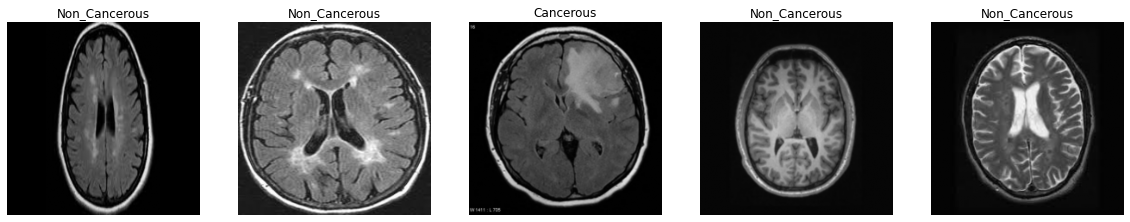

In [11]:
# Viewing Image - After Shuffle 

fig, ax = plt.subplots(nrows = 1, ncols = 5, figsize = (20,20))

for i in tqdm(range(0, 5)):
    rand = np.random.randint(len(Image))
    ax[i].imshow(Image[rand])
    ax[i].axis('off')
    a = Label[rand]
    if a == 1:
        ax[i].set_title('Cancerous')
    else:
        ax[i].set_title('Non_Cancerous')

In [12]:
# Assigning Images and Label to new variable 

X = Image
y = Label

In [13]:
# Splitting Data - Training & Validation

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [14]:
# Checking Shape 

X_train.shape, X_val.shape

((177, 224, 224, 3), (76, 224, 224, 3))

### DATA AUGMENTATION

In [15]:
# Creating augmentation object

train_datagen  = ImageDataGenerator(rescale = 1./255,
                                    width_shift_range = 0.05,
                                    height_shift_range = 0.05,
                                    horizontal_flip = True,
                                    vertical_flip = True,
                                    rotation_range = 30,
                                    fill_mode = 'nearest',
                                    zoom_range = 0.2,
                                    shear_range = 0.2)

# Fitting to train data 
train_datagen.fit(X_train)

### MODEL BUILDING

> `MODEL INITIALIATION`

In [16]:
model = Sequential()

> `BUILDING LAYERS`

In [17]:
# Input Layer 
model.add(InputLayer(input_shape = (224,224,3)))


# Adding Zero Padding
model.add(ZeroPadding2D((2,2), data_format = 'channels_last'))


# Adding Layers
model.add(Conv2D(filters = 32,  kernel_size  = (3, 3), strides=(2, 2), padding='valid', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2, 2), padding = 'valid'))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64,  kernel_size  = (3, 3), strides=(2, 2), padding='valid', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2, 2), padding = 'valid'))
model.add(Dropout(0.25))


# Adding Flatten
model.add(Flatten())


# Adding Dense-FCC
model.add(Dense(units = 128, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))


# Adding Output 
model.add(Dense(units = 1, activation = 'sigmoid'))

> `MODEL SUMMARY`

In [18]:
# Checking Summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d (ZeroPadding2 (None, 228, 228, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 113, 113, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 113, 113, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 56, 56, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 56, 56, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 27, 27, 64)        2

> `MODEL COMPILE`

In [19]:
##model.compile(optimizer = tensorflow.keras.optimizers.Adam(1e-5), loss = 'binary_crossentropy', metrics = ['accuracy'])

model.compile(optimizer = tensorflow.keras.optimizers.Adam(1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])

> `DEFINING CALLBACKS`

In [20]:
filepath = './best_weights.hdf5'

earlystopping = EarlyStopping(monitor = 'val_accuracy', 
                              mode = 'max' , 
                              patience = 15)

checkpoint    = ModelCheckpoint(filepath, 
                                monitor = 'val_accuracy', 
                                mode='max', 
                                save_best_only=True, 
                                verbose = 1)

callback_list = [earlystopping, checkpoint]

> `MODEL RUN`

In [21]:
batchSize = 64

if 1 :
   history = model.fit(train_datagen.flow(X_train, y_train, batch_size = batchSize),
          validation_data = (X_val, y_val),
          epochs = 10,
          verbose = 1,
          callbacks = callback_list)

if 0 :
   history = model.fit(X_train, y_train, batch_size = 32,
          validation_data = (X_val, y_val),
          epochs = 10,
          verbose = 1,
          callbacks = callback_list)



Epoch 1/10
3/3 [==============================] - 6s 1s/step - loss: 0.8786 - accuracy: 0.5537 - val_loss: 0.6717 - val_accuracy: 0.7632

Epoch 00001: val_accuracy improved from -inf to 0.76316, saving model to ./best_weights.hdf5
Epoch 2/10
3/3 [==============================] - 4s 1s/step - loss: 0.6246 - accuracy: 0.7062 - val_loss: 0.6663 - val_accuracy: 0.7500

Epoch 00002: val_accuracy did not improve from 0.76316
Epoch 3/10
3/3 [==============================] - 4s 1s/step - loss: 0.7325 - accuracy: 0.6836 - val_loss: 0.6671 - val_accuracy: 0.7632

Epoch 00003: val_accuracy did not improve from 0.76316
Epoch 4/10
3/3 [==============================] - 4s 1s/step - loss: 0.5478 - accuracy: 0.7627 - val_loss: 0.6702 - val_accuracy: 0.7763

Epoch 00004: val_accuracy improved from 0.76316 to 0.77632, saving model to ./best_weights.hdf5
Epoch 5/10
3/3 [==============================] - 4s 1s/step - loss: 0.6449 - accuracy: 0.7175 - val_loss: 0.6751 - val_accuracy: 0.7763

Epoch 00005

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Cancerous Cell


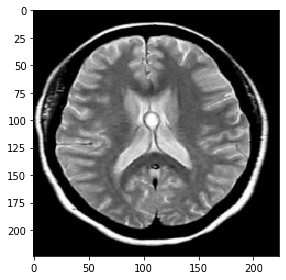

In [22]:
# Model Prediction

image = imread('yes/Y117.JPG')
image = resize(image, (224,224,3))
imshow(image)
image = np.expand_dims(image, 0)

prediction  = model.predict_classes(image)

if prediction[0][0] == 1:
    print("Cancerous Cell")
else:
    print("Non-Cancerous Cell")

# Plot the accuracy
Source  https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/

In [23]:
import matplotlib.pyplot as plt
import numpy

print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


KeyError: ignored

# Confusion matrix

In [24]:
y_pred_class = [] 
for xx,yy in zip(X_val, y_val) :
    #print(type(xx), xx.shape)
    #imshow(xx)
    xx_ = np.expand_dims(xx, 0)
    y_pred  = model.predict_classes(xx_)
    print(yy, y_pred[0][0])
    y_pred_class.append(y_pred[0][0])

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


0 1
0 0
1 1
1 1
0 1
1 1
0 1
0 1
1 1
0 1
0 1
1 1
1 1
0 1
0 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
1 1
0 1
0 1
1 1
1 1
1 1
0 1
0 1
1 1
1 1
1 1
0 0
1 1
1 1
1 1
1 1
0 1
0 1
1 1
1 1
1 1
1 1
1 1
1 1
0 1
0 1
1 1
1 1
0 1
1 1
1 1
1 1
0 1
1 1
1 1
0 1
0 1
1 1
1 1
0 1
0 1
0 1
1 1
0 1
0 1
0 1
1 1
1 1
0 1
1 1
1 1
1 1
1 1
1 1


In [ ]:
#from sklearn.metrics import plot_confusion_matrix


In [25]:
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_val,y_pred_class)
print(cm)

[[ 2 27]
 [ 0 47]]
